In [6]:
#%% Import all necessary libraries
import sys
sys.path.insert(0, '../modules')
import os.path
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 10})
from sklearn.decomposition import PCA
from scipy import optimize
import pandas as pd
import time
import napari
from matmatrix import consistentPCA, hullAnalysis, EuAngfromN, MSDfit
import imProcess
import msd
from msd import regMSD, trans_stepSize, rot_stepSize
from lmfit import Model
from scipy.special import erf
import movingHx  
import glob

In [7]:
# load raw images (sample files)
this_file_dir = os.path.dirname(os.path.dirname(os.path.abspath("./")))
folderName = "20220222_suc70_MT"
samplePath = os.path.join(this_file_dir,
                        "DNA-Rotary-Motor", "Helical-nanotubes",
                        "Light-sheet-OPM", "Result-data",
                        folderName)
intensityFiles = glob.glob(samplePath + '\*.npy')
print(intensityFiles)
stackRaw = np.array(da.from_npy_stack(intensityFiles[3]))
print(intensityFiles[3])

['C:\\Users\\labuser\\Dropbox (ASU)\\Research\\DNA-Rotary-Motor\\Helical-nanotubes\\Light-sheet-OPM\\Result-data\\20220222_suc70_MT\\20220215_franky_MT_70suc-data01-A.npy', 'C:\\Users\\labuser\\Dropbox (ASU)\\Research\\DNA-Rotary-Motor\\Helical-nanotubes\\Light-sheet-OPM\\Result-data\\20220222_suc70_MT\\20220215_franky_MT_70suc-data02-A.npy', 'C:\\Users\\labuser\\Dropbox (ASU)\\Research\\DNA-Rotary-Motor\\Helical-nanotubes\\Light-sheet-OPM\\Result-data\\20220222_suc70_MT\\20220215_franky_MT_70suc-data02-B.npy', 'C:\\Users\\labuser\\Dropbox (ASU)\\Research\\DNA-Rotary-Motor\\Helical-nanotubes\\Light-sheet-OPM\\Result-data\\20220222_suc70_MT\\20220215_franky_MT_70suc-data04-A.npy']


KeyboardInterrupt: 

In [186]:
# binarization of the image 
blobBin = []
# for frame in range(len(stackRaw)):
for frame in range(100,300):

    thresvalue = 0.8; sizes = 0;   
    fromImgPro = imProcess.ImPro(stackRaw[frame],thresvalue)
    img = fromImgPro.thresVol()                   # binary image
    sizes = max(fromImgPro.selectLargest()[0])    # largest body only
    
#     att = 0;
#     if sizes < 900:
#        att = 1
#        while sizes < 900 and att < 20: 
#            thresvalue = thresvalue + 0.05
#            fromImgPro = imProcess.ImPro(intensity[frame],thresvalue)
#            img = fromImgPro.thresVol()                 
#            sizes = max(fromImgPro.selectLargest()[0])
#            att = att + 1
#     thres_dur = time.perf_counter() - tstart_thresh
#     print("thresholding took %0.2fs with %d attemps"\
#          % (thres_dur, att))
            
    blob = fromImgPro.BlobAndSkel()
    blobBin.append(blob)
    # print("number of frames = %.2f" %frame)
blobBin = da.from_array(blobBin)

In [187]:
# Check binarization
viewer = napari.Viewer(ndisplay=3)      
viewer.add_image(stackRaw, contrast_limits=[100,140],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='gray',opacity=0.5)
viewer.add_image(blobBin, contrast_limits=[0,1],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='green',opacity=0.5)
viewer.scale_bar.visible=True
viewer.scale_bar.unit='um'
viewer.scale_bar.position='top_right'
viewer.axes.visible = True
napari.run()

C:\Users\labuser\miniconda3\envs\dhanush\lib\site-packages\naparimovie\scriptcommands.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  command_list = np.array(command_list)
C:\Users\labuser\miniconda3\envs\dhanush\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


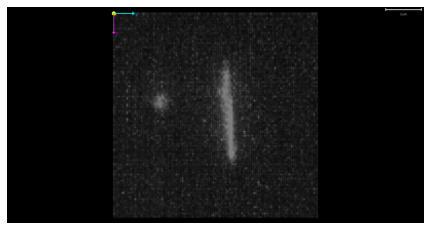

In [188]:
# save movie  
resultPath = os.path.join(this_file_dir,
                          "DNA-Rotary-Motor", "Helical-nanotubes",
                          "Light-sheet-OPM", "Result-data",
                          "20220222_suc70_MT")
dataName = "20220215_franky_MT_70suc"

from naparimovie import Movie
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(stackRaw, contrast_limits=[100,140],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='gray',opacity=0.5)
# viewer.add_image(blobBin, contrast_limits=[0,1],\
#                     scale=[0.115,.115,.115],\
#                     multiscale=False,colormap='green',opacity=0.5)
viewer.scale_bar.visible=True
viewer.scale_bar.unit='um'
viewer.scale_bar.position='top_right'
viewer.axes.visible = True
movie = Movie(myviewer=viewer)
movie.create_state_dict_from_script('../moviecommands/mcTime.txt')
movie.make_movie(os.path.join(resultPath, dataName+"-data04-threshold-A.mov"),fps=10)

In [184]:
# Analyze the threholded image
xb = []; xb0 = []; xp = []; xp0 = []
eigenvec = []; xb0 = []

Nframes = len(blobBin)
lenfla = np.zeros(Nframes)
cm = np.zeros([Nframes,3])
eigenvec = np.zeros([Nframes,3,3])
coord = []
localAxes = np.zeros([Nframes,3,3])
endpt = np.zeros([Nframes,3])
whEnd = 1

for frame in range(Nframes):
# for frame in range(10):

    blob = np.array(blobBin[frame])

    X0 = np.argwhere(blob).astype('float') 
    CM1 = np.array([sum(X0[:,j]) for j in range(X0.shape[1])])/X0.shape[0]

    xb.append(X0); cm[frame,:] = CM1

    # Use PCA to find the rotation matrix
    X = X0 - CM1 # shift all the coordinates into origin
    pca = PCA(n_components=3)
    pca.fit(X)
    axes = whEnd*pca.components_
    xb0.append(X)

    # Make the PCA consistent
    if frame == 0:
        axes_ref = axes
    else:
        axes, axes_ref = consistentPCA(axes, axes_ref)

    # Find the flagella length and endpoint in the direction of n1
    lenfla[frame], endpt[frame] = hullAnalysis(X,axes)

    # Use Gram-Schmidt to find n2, then find n3 with the cross
    n1 = axes[0] / np.linalg.norm(axes[0])
    n2 = endpt[frame] - np.array([0,0,0])
    n2 -= n2.dot(n1) * n1 / np.linalg.norm(n1)**2
    n2 /= np.linalg.norm(n2)
    n3 = np.cross(n1,n2)
    n3 /= np.linalg.norm(n3)
    localAxes[frame,0] = n1
    localAxes[frame,1] = n2
    localAxes[frame,2] = n3

    # Rotate to the principal axes
    P0 = np.matmul(axes,X.T).T
    xp0.append(P0)  
    eigenvec[frame] = axes

    # Print each volume frame has finished
    end = time.perf_counter()
    # print('frame#: %d\n' %frame)

# compute pitch, roll, and yaw (Bernie's method)
EuAng = EuAngfromN(localAxes)
n1 = localAxes[:,0]; n2 = localAxes[:,1]; n3 = localAxes[:,2]

# compute translation displacement
disp_N, disp_S1, disp_S2 = msd.trans_stepSize_Namba(cm, n1, n2, n3)
disp = np.stack([disp_N, disp_S1, disp_S2]).T

0.5526828966925805


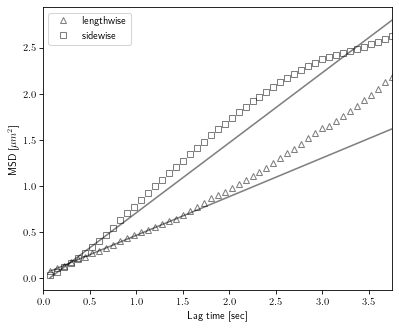

In [181]:
# Perform vector analysis & MSD
# initialize msd
msd_N = []; msd_S1 = []; msd_S2 = []; msd_NR = []
msd_P = []; msd_R = []; msd_Y = []; msd_CM = []
nInterval = 50

# compute 3D exposure time
pxum = 0.115; 
camExposure_ms = 2
sweep_um = 15
stepsize_nm = 400
exp3D_ms = 1e-3 * camExposure_ms * (sweep_um*1e3/stepsize_nm) 

# center-of-mass tracking
dstCM = np.zeros(len(cm))
for i in range(len(cm)): dstCM[i] = np.linalg.norm(cm[i])

# MSD: mean square displacement
MSD_N, MSD_S1, MSD_S2, MSD_NR = msd.trans_MSD_Namba(Nframes,
                                          cm, EuAng[:,1],
                                          n1, n2, n3,
                                          exp3D_ms, nInterval)
MSD_P = msd.regMSD(Nframes, EuAng[:,0], exp3D_ms, nInterval)
MSD_R = msd.regMSD(Nframes, EuAng[:,1], exp3D_ms, nInterval)
MSD_Y = msd.regMSD(Nframes, EuAng[:,2], exp3D_ms, nInterval)
MSD_CM = msd.regMSD(Nframes, dstCM, exp3D_ms, nInterval)

msd_N.append(MSD_N); msd_S1.append(MSD_S1); msd_S2.append(MSD_S2)
msd_NR.append(MSD_NR)
msd_P.append(MSD_P); msd_R.append(MSD_R); msd_Y.append(MSD_Y)
msd_CM.append(MSD_CM)

# Fit MSD with y = Const + B*x for N, S, NR, PY, R
Nfit = 10
xtime = np.linspace(1,Nfit,Nfit)
fit_N,fitN_const  = optimize.curve_fit(MSDfit, xtime, MSD_N[0:Nfit])[0]
fit_S,fitS_const  = optimize.curve_fit(MSDfit, xtime,
                        np.mean([MSD_S1[0:Nfit],MSD_S2[0:Nfit]],axis=0))[0]
fit_NR,fitNR_const = optimize.curve_fit(MSDfit, xtime, MSD_NR[0:Nfit])[0]
fit_PY,fitPY_const = optimize.curve_fit(MSDfit, xtime,
                          np.mean([MSD_P[0:Nfit],MSD_Y[0:Nfit]],axis=0))[0]
fit_R,fitR_const   = optimize.curve_fit(MSDfit, xtime, MSD_R[0:Nfit])[0]
fit_CM,fitCM_const = optimize.curve_fit(MSDfit, xtime, MSD_CM[0:Nfit])[0]

# Additional fit
fit_S1,fitP_const  = optimize.curve_fit(MSDfit, xtime, MSD_S1[0:Nfit])[0]
fit_S2,fitY_const  = optimize.curve_fit(MSDfit, xtime, MSD_S2[0:Nfit])[0]
fit_P, fitP_const  = optimize.curve_fit(MSDfit, xtime, MSD_P[0:Nfit])[0]
fit_Y, fitY_const  = optimize.curve_fit(MSDfit, xtime, MSD_Y[0:Nfit])[0]

# plot MSD and fit
xaxis = np.arange(1,nInterval+1)
fig0,ax0 = plt.subplots(dpi=75, figsize=(6,5))
ax0.plot(xaxis*exp3D_ms,MSD_N,c='k',marker="^",mfc='none',
          ms=5,ls='None',alpha=0.5)   
ax0.plot(xaxis*exp3D_ms,np.mean([MSD_S1,MSD_S2],axis=0),
         c='k',marker="s",mfc='none',
          ms=5,ls='None',alpha=0.5)
ax0.plot(xaxis*exp3D_ms,fitN_const + fit_N*xaxis,
         c='k',alpha=0.5,label='_nolegend_')
ax0.plot(xaxis*exp3D_ms,fitS_const + fit_S*xaxis,
         c='k',alpha=0.5,label='_nolegend_')
ax0.set_xlabel(r'Lag time [sec]');
ax0.set_ylabel(r'MSD [$\mu m^2$]')
# ax0.set_ylim([0, 2]);
ax0.set_xlim([0, nInterval*exp3D_ms])
ax0.legend(["lengthwise","sidewise"])

print(fit_N/fit_S)

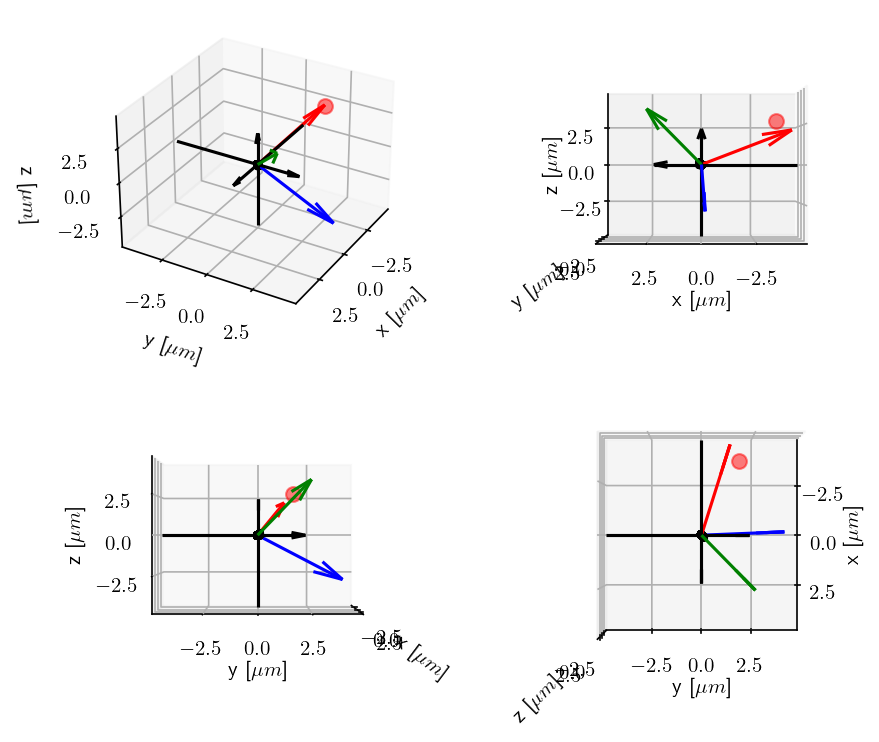

In [105]:
# for frame in range(len(blobBin)):
for frame in range(1):
        
    X0 = np.array(blobBin[frame])
    CM1 = np.array([sum(X0[:,j]) for j in range(X0.shape[1])])/X0.shape[0]
    xb0 = X0 - CM1

    fig = plt.figure(dpi=150, figsize = (7, 6))
#     fig.suptitle('data: %s\n' %ThName +
#                  'frame-num = ' + str(frame).zfill(3) + ', '
#                  'length = %.3f $\mu$m\n' %np.round(lenfla[frame],3) +
#                  '$\Delta_\parallel$ = %.3f $\mu$m, ' %np.round(disp[frame,0],3) +
#                  '$\Delta_{\perp 1}$ = %.3f $\mu$m, ' %np.round(disp[frame,1],3) +
#                  '$\Delta_{\perp 2}$ = %.3f $\mu$m\n' %np.round(disp[frame,2],3) +
#                  '$\Delta_\psi$ = %.3f rad, ' %np.round(EuAng[frame,1],3) +
#                  '$\Delta_\gamma$ = %.3f rad, ' %np.round(EuAng[frame,0],3) +
#                  '$\Delta_\phi$ = %.3f rad\n' %np.round(EuAng[frame,2],3)
#                  )
    ax0 = fig.add_subplot(221,projection='3d')
    ax2 = fig.add_subplot(222,projection='3d')
    ax3 = fig.add_subplot(223,projection='3d')
    ax4 = fig.add_subplot(224,projection='3d')
    pxum = 0.115

    ## plot 1
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax0.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax0.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax0.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax0.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax0.view_init(elev=30, azim=30)
    ax0.set_xlabel(r'x [$\mu m$]'); ax0.set_ylabel(r'y [$\mu m$]')
    ax0.set_zlabel(r'z [$\mu m$]')
    ax0.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax0.scatter(endpt[frame,0]*pxum,\
                endpt[frame,1]*pxum,\
                endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax0.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax0.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax0.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')

    ## plot 2
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax2.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax2.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax2.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax2.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax2.view_init(elev=0, azim=90)
    ax2.set_xlabel(r'x [$\mu m$]'); ax2.set_ylabel(r'y [$\mu m$]')
    ax2.set_zlabel(r'z [$\mu m$]')
    ax2.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax2.scatter(endpt[frame,0]*pxum,\
                endpt[frame,1]*pxum,\
                endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax2.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax2.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax2.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')

    ## plot 3
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax3.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax3.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax3.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax3.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax3.view_init(elev=0, azim=0)
    ax3.set_xlabel(r'x [$\mu m$]'); ax3.set_ylabel(r'y [$\mu m$]')
    ax3.set_zlabel(r'z [$\mu m$]')
    ax3.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax3.scatter(endpt[frame,0]*pxum,\
               endpt[frame,1]*pxum,\
               endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax3.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax3.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax3.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')

    ## plot 4
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax4.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax4.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax4.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax4.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax4.view_init(elev=90, azim=0)
    ax4.set_xlabel(r'x [$\mu m$]'); ax4.set_ylabel(r'y [$\mu m$]')
    ax4.set_zlabel(r'z [$\mu m$]')
    ax4.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax4.scatter(endpt[frame,0]*pxum,\
               endpt[frame,1]*pxum,\
               endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax4.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax4.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax4.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')
    #ax4.figure.savefig(os.path.join(savingFolder, ThName + '-' + 
    #                                str(frame).zfill(3) + '.png'))
#     ax4.show()

In [140]:
fit_N/fit_S

1.2220531826690775

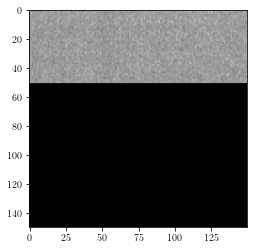

In [29]:
fig = plt.Figure()
plt.imshow(test[0,20,:,:],cmap='gray', vmin=0, vmax=200)

In [8]:
test

NameError: name 'test' is not defined

In [ ]:
test = da.from_npy_stack(intensityFiles[0])
viewer = napari.Viewer(ndisplay=3)      
viewer.add_image(test, contrast_limits=[100,200],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='gray',opacity=0.5)
viewer.add_image(stackTh, contrast_limits=[0,1],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='green',opacity=0.5)
viewer.scale_bar.visible=True
viewer.scale_bar.unit='um'
viewer.scale_bar.position='top_right'
viewer.axes.visible = True
napari.run()